In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files    # download kaggle.json
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naruto404","key":"efc2ded70d59040d686668649b6ed23c"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d gpiosenka/good-guysbad-guys-image-data-set

 99% 581M/586M [00:22<00:00, 30.5MB/s]
100% 586M/586M [00:22<00:00, 27.2MB/s]


In [5]:
!unzip -q /content/good-guysbad-guys-image-data-set.zip -d ./ && rm /content/good-guysbad-guys-image-data-set.zip

In [6]:
!pip -q install -U albumentations
!pip -q uninstall opencv-contrib-python
!pip -q install opencv-contrib-python==4.5.5.64 

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.8 MB 2.5 MB/s 
Proceed (y/n)? y
     |████████████████████████████████| 66.7 MB 26 kB/s 


In [7]:
import torch
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import albumentations as A
from albumentations.augmentations import transforms as AT
from albumentations.pytorch.transforms import ToTensorV2

import os
import random
from tqdm import tqdm
from datetime import datetime
from copy import deepcopy

In [8]:
print('Size of trains:', len(os.listdir('train/savory')) + len(os.listdir('train/unsavory')))
print('Size of vals:', len(os.listdir('valid/savory')) + len(os.listdir('valid/unsavory')))
print('Size of tests:', len(os.listdir('test/savory')) + len(os.listdir('test/unsavory')))

Size of trains: 11220
Size of vals: 600
Size of tests: 600


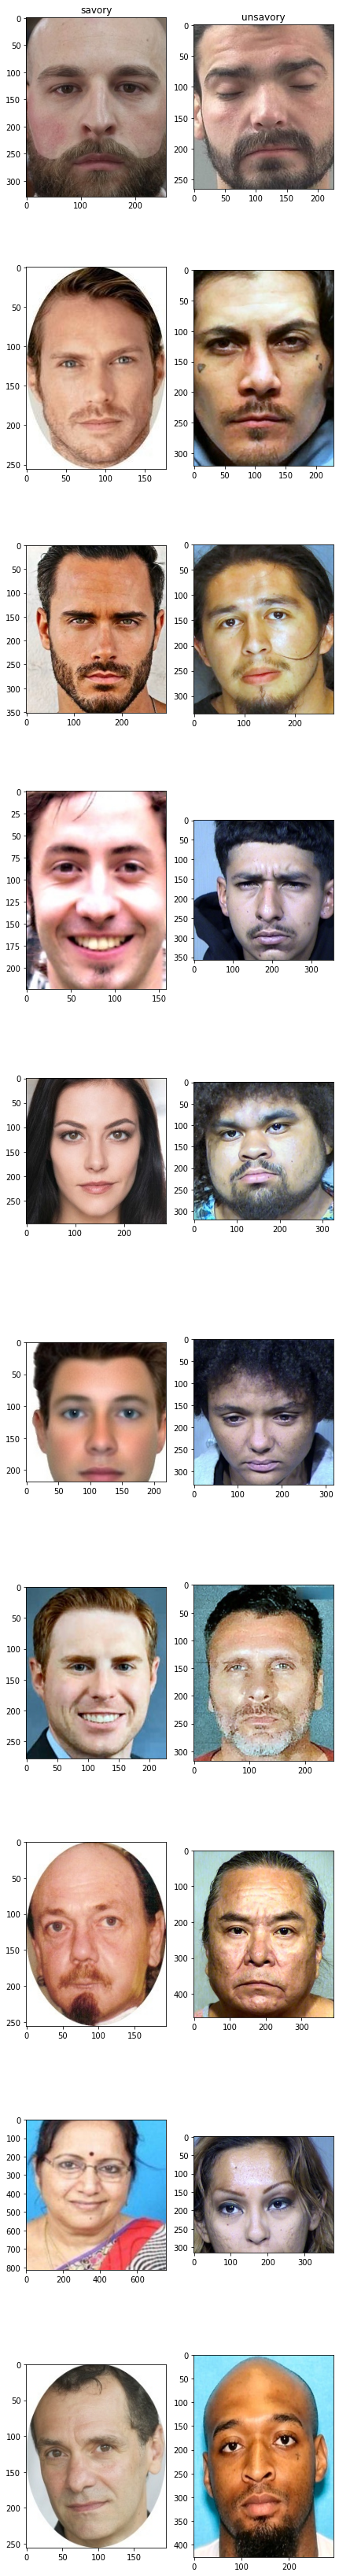

In [9]:
fig, axes = plt.subplots(10, 2, figsize=(7, 60))

sav_list = os.listdir('train/savory')
unsav_list = os.listdir('train/unsavory')

for idx, images in enumerate(zip(sav_list, unsav_list)):
    savory_path = os.path.join('train/savory', images[0])
    unsavory_path = os.path.join('train/unsavory', images[1])

    savory = cv2.imread(savory_path)
    unsavory = cv2.imread(unsavory_path)

    savory = cv2.cvtColor(savory, cv2.COLOR_BGR2RGB)
    unsavory = cv2.cvtColor(unsavory, cv2.COLOR_BGR2RGB)

    if idx == 0:
        axes[idx, 0].set_title('savory')
        axes[idx, 1].set_title('unsavory')
    if idx == 10:
        break

    axes[idx, 0].imshow(savory)
    axes[idx, 1].imshow(unsavory)

In [10]:
all_paths = []

for folder in ['train', 'valid', 'test']:
    for class_ in ['savory', 'unsavory']:
        images_path = os.path.join(folder, class_)

        for name_image in os.listdir(images_path):
            full_path = os.path.join(images_path, name_image)
            
            all_paths.append(full_path)

In [11]:
sizes = set()

for path in all_paths:
    with Image.open(path) as image:                 # it is faster than cv2.imread().shape
        sizes.add(image.size)

sizes = np.array(list(sizes))
print('Number of uniques sizes:', len(sizes))
print('Unique sizes:', sizes)

Number of uniques sizes: 7500
Unique sizes: [[266 351]
 [158 193]
 [256 345]
 ...
 [521 626]
 [205 201]
 [243 298]]


In [12]:
median_size = np.median(sizes, axis=0)
median_size = median_size[:2].astype(np.int32)
median_size = tuple(median_size)

print('Median width:', median_size[0])
print('Median height:', median_size[1])

Median width: 290
Median height: 352


In [13]:
intensity = []

for path in all_paths:
    image = cv2.imread(path)
    image = cv2.resize(image, median_size, interpolation=cv2.INTER_LINEAR)
    intensity.append(image.sum())

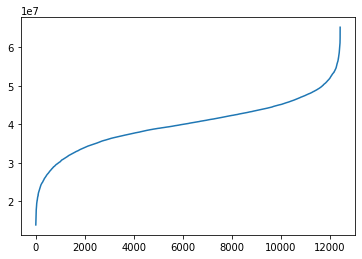

In [14]:
sns.lineplot(x=range(len(intensity)), y=sorted(intensity))

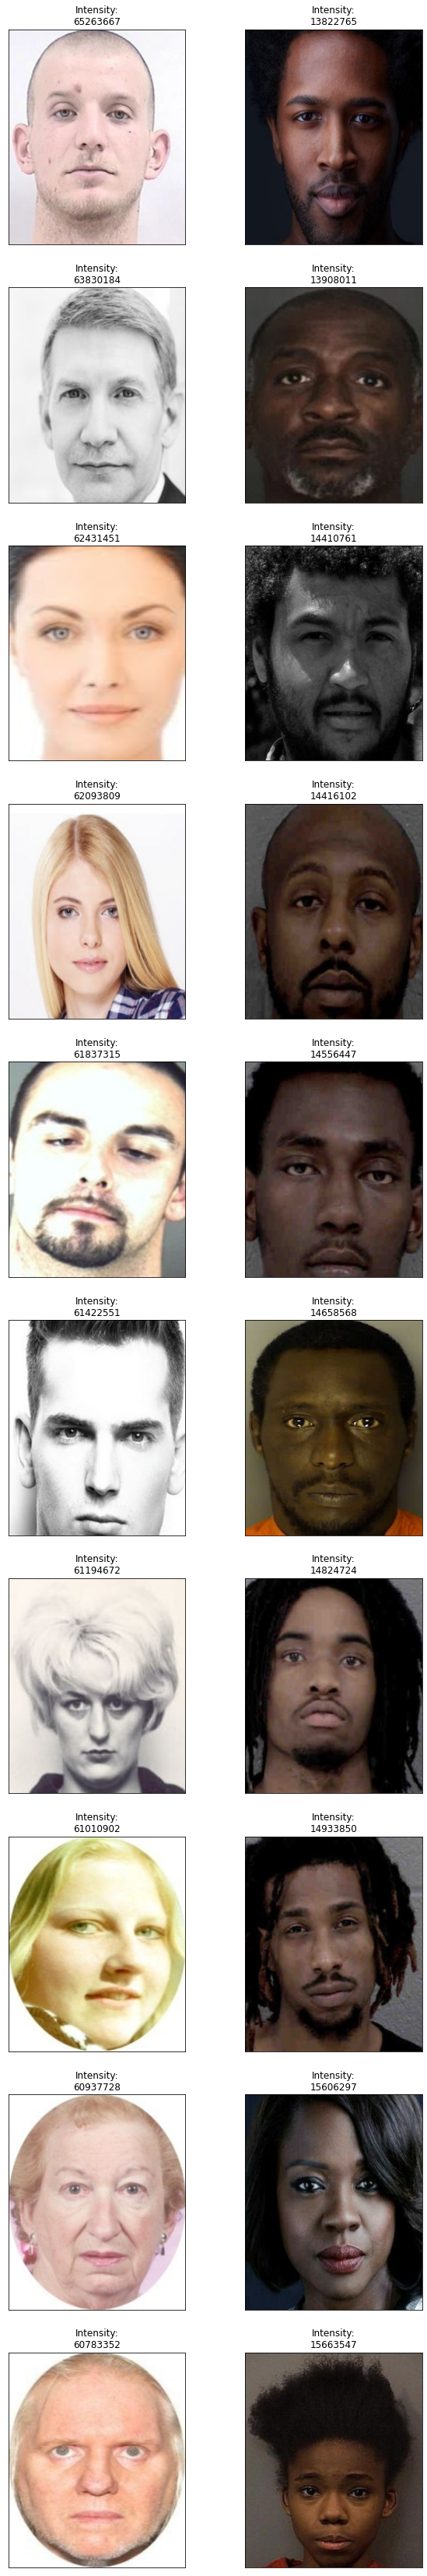

In [15]:
intensity_path = list(tuple(zip(all_paths, intensity)))
intensity_path.sort(key=lambda x: x[1])

fig, axes = plt.subplots(10, 2, figsize=(10, 60))    # show images and their intensity

for i in range(10):
    path_bright = intensity_path[-i - 1][0]
    intens_bright = intensity_path[-i - 1][1]   

    path_dark = intensity_path[i][0]
    intens_dark = intensity_path[i][1]

    image_bright = cv2.imread(path_bright, cv2.IMREAD_COLOR)
    image_bright = cv2.resize(image_bright, median_size, interpolation=cv2.INTER_LINEAR)
    image_dark = cv2.imread(path_dark, cv2.IMREAD_COLOR)
    image_dark = cv2.resize(image_dark, median_size, interpolation=cv2.INTER_LINEAR)

    image_bright = cv2.cvtColor(image_bright, cv2.COLOR_BGR2RGB)
    image_dark = cv2.cvtColor(image_dark, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_bright)
    axes[i, 0].set_title(f'Intensity:\n{intens_bright}')
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].imshow(image_dark)
    axes[i, 1].set_title(f'Intensity:\n{intens_dark}')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

In [22]:
class Dataset_peoples(Dataset):
    
    def __init__(self, folder, size=(290, 352), transforms=None, input_dir='./'):
        self.input_dir = input_dir

        self.classes = ['savory', 'unsavory']
        self.paths = self._load_objects(folder, 'paths')
        self.targets = self._load_objects(folder, 'targets')

        self.transforms = transforms
        self.size = size
    
    def _load_objects(self, folder, mode):
        full_objects = []
        path_to_folder = os.path.join(self.input_dir, folder)

        for class_ in os.listdir(path_to_folder):
            path_to_images = os.path.join(path_to_folder, class_)

            for name_image in os.listdir(path_to_images):               
                if mode == 'targets':
                    full_objects.append(self.classes.index(class_))
                elif mode == 'paths':
                    full_path = os.path.join(path_to_images, name_image)
                    full_objects.append(full_path)
        
        return np.array(full_objects)
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_AREA)

        if self.transforms:
            image = self.transforms(image=image)['image']

        target = self.targets[idx]

        return image / 255.0, target


In [23]:
test_aug = A.Compose([
                      AT.Blur(p=0.2),
                      AT.ChannelShuffle(),
                      AT.ColorJitter(p=0.4, contrast=0.1, saturation=0.1),
                      AT.Equalize(p=0.3),
                      AT.Flip(p=0.3),
                      AT.VerticalFlip(p=0.3),
                      AT.GaussNoise(p=0.3),
                      ToTensorV2()
])

In [24]:
test_dataset = Dataset_peoples('train', size=(290, 352), transforms=test_aug)

0


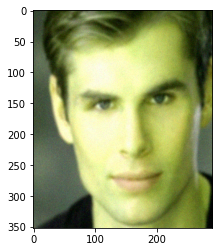

In [51]:
plt.imshow(cv2.cvtColor(test_dataset[1000][0].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
print(test_dataset[1000][1])

In [52]:
train_aug = A.Compose([
                AT.Blur(p=0.2),
                AT.ChannelShuffle(),
                AT.ColorJitter(p=0.4, contrast=0.1, saturation=0.1),
                AT.Equalize(p=0.3),
                AT.Flip(p=0.3),
                AT.VerticalFlip(p=0.3),
                AT.GaussNoise(p=0.3),
                ToTensorV2()
])
valid_aug = ToTensorV2()
test_aug = ToTensorV2()

In [55]:
pin_memory = True if torch.cuda.is_available() else False

train_dataset = Dataset_peoples('train', transforms=train_aug)
valid_dataset = Dataset_peoples('valid', transforms=valid_aug)
test_dataset = Dataset_peoples('test', transforms=test_aug)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, pin_memory=pin_memory,
                          num_workers=2)

valid_loader = DataLoader(valid_dataset, batch_size=64,
                          shuffle=True, pin_memory=pin_memory,
                          num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=64,
                          shuffle=False, pin_memory=pin_memory,
                         num_workers=2)

In [57]:
def train(model, loader_train, loader_valid, epochs, optim, loss_func, device,
          checkpoint_path=None, scheduler=None, return_history=False):
    loader = {'train': loader_train, 'valid': loader_valid}
    loss_history = []
    accuracy_history = []

    best_state_dict = None
    smallest_loss = np.inf

    for epoch in range(epochs):
        for mode in ['train', 'valid']:
            if mode == 'valid':
                model.eval()
            else:
                model.train()

            loss_epoch = 0
            accuracy_epoch = 0
            loop = tqdm(loader[mode])
            loop.set_description(f'Epoch [{epoch}/{epochs}] |[{mode}]')

            for image, target in loop:
                torch.cuda.memory.empty_cache()
                image = image.to(device)
                target = target.to(device)

                pred = model(image)
                loss = loss_func(pred, target)
                _, pred_cls = torch.max(pred, 1)
                corrects = torch.sum(pred_cls == target)
                
                loop.set_postfix(loss=loss.item())

                if mode == 'train':
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                loss_epoch += loss.item()
                accuracy_epoch += corrects
            
            mean_loss_epoch = loss_epoch / len(loader[mode])
            mean_accuracy_epoch = accuracy_epoch / len(loader[mode].dataset)

            text0 = '\n' if epoch == epochs - 1 else ''
            text1 = f'Mean loss: {mean_loss_epoch}\n'
            text2 = f'Mean accuracy: {mean_accuracy_epoch}\n'
            loop.write(text0 + text1 + text2)

            if mode == 'valid' and mean_loss_epoch < smallest_loss:
                best_state_dict = deepcopy(model.state_dict())
                
                if checkpoint_path:
                  checkpoint = model.state_dict()
                  torch.save(checkpoint, checkpoint_path)

            if scheduler and mode == 'train':
                scheduler.step(mean_loss_epoch)

            if return_history is True:
                loss_history.append(mean_loss_epoch)
                accuracy_history.append(mean_accuracy_epoch)
    
    if return_history is True:
        return {'state_dict': best_state_dict,
                'loss_history': loss_history,
                'accuracy_history': accuracy_history}
    else:
        return best_state_dict


In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [ ]:
model = models.resnet18()
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 2)
model.to(device)

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [62]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [63]:
loss_func = torch.nn.CrossEntropyLoss()

In [64]:
state_dict = train(model, train_loader, valid_loader, 30, optimizer, loss_func, device,
                   checkpoint_path='/content/drive/MyDrive/My_pth-s/Good_and_no_peoples.pth',
                   scheduler=scheduler, return_history=True)

Epoch [0/30] |[train]: 100%|██████████| 176/176 [03:35<00:00,  1.22s/it, loss=0.641]


Mean loss: 0.7179922793399204
Mean accuracy: 0.611140787601471



Epoch [0/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s, loss=0.509]


Mean loss: 0.5415084064006805
Mean accuracy: 0.7200000286102295



Epoch [1/30] |[train]: 100%|██████████| 176/176 [03:04<00:00,  1.05s/it, loss=0.402]


Mean loss: 0.6102150218053297
Mean accuracy: 0.6707664728164673



Epoch [1/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s, loss=0.479]


Mean loss: 0.5171809315681457
Mean accuracy: 0.7150000333786011



Epoch [2/30] |[train]: 100%|██████████| 176/176 [03:16<00:00,  1.12s/it, loss=0.456]


Mean loss: 0.5605222533710978
Mean accuracy: 0.7076649069786072



Epoch [2/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, loss=0.597]


Mean loss: 0.5185549676418304
Mean accuracy: 0.7166666984558105



Epoch [3/30] |[train]: 100%|██████████| 176/176 [03:03<00:00,  1.04s/it, loss=0.621]


Mean loss: 0.5337864898822524
Mean accuracy: 0.7291443943977356



Epoch [3/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s, loss=0.615]


Mean loss: 0.4939956098794937
Mean accuracy: 0.7700000405311584



Epoch [4/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.433]


Mean loss: 0.509446129372174
Mean accuracy: 0.7445632815361023



Epoch [4/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=0.499]


Mean loss: 0.5503589957952499
Mean accuracy: 0.7033333778381348



Epoch [5/30] |[train]: 100%|██████████| 176/176 [03:10<00:00,  1.08s/it, loss=0.615]


Mean loss: 0.479154138233174
Mean accuracy: 0.7692513465881348



Epoch [5/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s, loss=0.328]


Mean loss: 0.43933371007442473
Mean accuracy: 0.7766667008399963



Epoch [6/30] |[train]: 100%|██████████| 176/176 [03:10<00:00,  1.08s/it, loss=0.557]


Mean loss: 0.4663463644683361
Mean accuracy: 0.7788770198822021



Epoch [6/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=0.497]


Mean loss: 0.5523145824670792
Mean accuracy: 0.7416666746139526



Epoch [7/30] |[train]: 100%|██████████| 176/176 [03:03<00:00,  1.04s/it, loss=0.485]


Mean loss: 0.43239674463190814
Mean accuracy: 0.7968805432319641



Epoch [7/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=0.597]


Mean loss: 0.4318972438573837
Mean accuracy: 0.800000011920929



Epoch [8/30] |[train]: 100%|██████████| 176/176 [03:10<00:00,  1.08s/it, loss=0.531]


Mean loss: 0.40959947869520297
Mean accuracy: 0.8131906986236572



Epoch [8/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=0.24]


Mean loss: 0.40646816343069075
Mean accuracy: 0.8083333373069763



Epoch [9/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.421]


Mean loss: 0.4039051916280931
Mean accuracy: 0.8183600902557373



Epoch [9/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s, loss=0.243]


Mean loss: 0.4187479868531227
Mean accuracy: 0.8016666769981384



Epoch [10/30] |[train]: 100%|██████████| 176/176 [03:10<00:00,  1.08s/it, loss=0.507]


Mean loss: 0.36684777155857196
Mean accuracy: 0.8368092775344849



Epoch [10/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s, loss=0.365]


Mean loss: 0.32913380563259126
Mean accuracy: 0.8516666889190674



Epoch [11/30] |[train]: 100%|██████████| 176/176 [03:10<00:00,  1.08s/it, loss=0.184]


Mean loss: 0.34960452738133346
Mean accuracy: 0.8459001779556274



Epoch [11/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s, loss=0.294]


Mean loss: 0.26523589342832565
Mean accuracy: 0.8983333706855774



Epoch [12/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.415]


Mean loss: 0.32421872062100604
Mean accuracy: 0.8575757741928101



Epoch [12/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s, loss=0.23]


Mean loss: 0.24887125045061112
Mean accuracy: 0.9083333611488342



Epoch [13/30] |[train]: 100%|██████████| 176/176 [03:20<00:00,  1.14s/it, loss=0.275]


Mean loss: 0.3100340065800331
Mean accuracy: 0.8673796653747559



Epoch [13/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s, loss=0.43]


Mean loss: 0.4545987993478775
Mean accuracy: 0.7800000309944153



Epoch [14/30] |[train]: 100%|██████████| 176/176 [03:19<00:00,  1.14s/it, loss=0.299]


Mean loss: 0.297731495462358
Mean accuracy: 0.8764705657958984



Epoch [14/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s, loss=0.119]


Mean loss: 0.2822322078049183
Mean accuracy: 0.8816666603088379



Epoch [15/30] |[train]: 100%|██████████| 176/176 [03:12<00:00,  1.09s/it, loss=0.127]


Mean loss: 0.2856732178479433
Mean accuracy: 0.8798573613166809



Epoch [15/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, loss=0.171]


Mean loss: 0.19045063555240632
Mean accuracy: 0.9166666865348816



Epoch [16/30] |[train]: 100%|██████████| 176/176 [03:19<00:00,  1.14s/it, loss=0.321]


Mean loss: 0.26909621948884294
Mean accuracy: 0.886185348033905



Epoch [16/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s, loss=0.335]


Mean loss: 0.24902556091547012
Mean accuracy: 0.8916667103767395



Epoch [17/30] |[train]: 100%|██████████| 176/176 [03:12<00:00,  1.09s/it, loss=0.0609]


Mean loss: 0.24721727774224497
Mean accuracy: 0.8980392217636108



Epoch [17/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=0.151]


Mean loss: 0.19118728265166282
Mean accuracy: 0.9266666769981384



Epoch [18/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.122]


Mean loss: 0.22664150786162776
Mean accuracy: 0.9057931900024414



Epoch [18/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s, loss=0.305]


Mean loss: 0.23174823075532913
Mean accuracy: 0.9183333516120911



Epoch [19/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.197]


Mean loss: 0.2282436711883003
Mean accuracy: 0.9066844582557678



Epoch [19/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s, loss=0.135]


Mean loss: 0.18123031109571458
Mean accuracy: 0.9316666722297668



Epoch [20/30] |[train]: 100%|██████████| 176/176 [03:17<00:00,  1.12s/it, loss=0.139]


Mean loss: 0.21108930454250763
Mean accuracy: 0.9160427451133728



Epoch [20/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, loss=0.0948]


Mean loss: 0.15869880095124245
Mean accuracy: 0.9366666674613953



Epoch [21/30] |[train]: 100%|██████████| 176/176 [03:19<00:00,  1.14s/it, loss=0.299]


Mean loss: 0.19646017981523817
Mean accuracy: 0.9229946732521057



Epoch [21/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s, loss=0.0867]


Mean loss: 0.1401647612452507
Mean accuracy: 0.9433333277702332



Epoch [22/30] |[train]: 100%|██████████| 176/176 [03:19<00:00,  1.14s/it, loss=0.0228]


Mean loss: 0.18993461614643986
Mean accuracy: 0.9228163957595825



Epoch [22/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, loss=0.276]


Mean loss: 0.16301501542329788
Mean accuracy: 0.9350000023841858



Epoch [23/30] |[train]: 100%|██████████| 176/176 [03:20<00:00,  1.14s/it, loss=0.239]


Mean loss: 0.17219961893914099
Mean accuracy: 0.9296791553497314



Epoch [23/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s, loss=0.361]


Mean loss: 0.33323138356208803
Mean accuracy: 0.8683333396911621



Epoch [24/30] |[train]: 100%|██████████| 176/176 [03:12<00:00,  1.09s/it, loss=0.194]


Mean loss: 0.16903414196250113
Mean accuracy: 0.9350267052650452



Epoch [24/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, loss=0.0868]


Mean loss: 0.1782299406826496
Mean accuracy: 0.9333333373069763



Epoch [25/30] |[train]: 100%|██████████| 176/176 [03:14<00:00,  1.11s/it, loss=0.238]


Mean loss: 0.1566009481268173
Mean accuracy: 0.9398395419120789



Epoch [25/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s, loss=0.113]


Mean loss: 0.17287586033344268
Mean accuracy: 0.9316666722297668



Epoch [26/30] |[train]: 100%|██████████| 176/176 [03:12<00:00,  1.10s/it, loss=0.198]


Mean loss: 0.14868845520752735
Mean accuracy: 0.9430481195449829



Epoch [26/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, loss=0.083]


Mean loss: 0.14254006259143354
Mean accuracy: 0.9466667175292969



Epoch [27/30] |[train]: 100%|██████████| 176/176 [03:21<00:00,  1.15s/it, loss=0.388]


Mean loss: 0.14189078703268684
Mean accuracy: 0.9441176652908325



Epoch [27/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s, loss=0.0288]


Mean loss: 0.14187130127102138
Mean accuracy: 0.9383333325386047



Epoch [28/30] |[train]: 100%|██████████| 176/176 [03:21<00:00,  1.15s/it, loss=0.297]


Mean loss: 0.12893534445373173
Mean accuracy: 0.9516042470932007



Epoch [28/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s, loss=0.217]


Mean loss: 0.12955153025686741
Mean accuracy: 0.9516667127609253



Epoch [29/30] |[train]: 100%|██████████| 176/176 [03:18<00:00,  1.13s/it, loss=0.134]



Mean loss: 0.12749286618253047
Mean accuracy: 0.9517825245857239



Epoch [29/30] |[valid]: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s, loss=0.209]



Mean loss: 0.12643832601606847
Mean accuracy: 0.9500000476837158



In [65]:
checkpoint = torch.load('/content/drive/MyDrive/My_pth-s/Good_and_no_peoples.pth', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [84]:
train_loss_history = []
train_accuracy_history = []
valid_loss_history = []
valid_accuracy_history = []

loss_hist = state_dict['loss_history']
acc_hist = state_dict['accuracy_history']

for i, data in enumerate(zip(loss_hist, acc_hist)):
    loss = data[0]
    acc = data[1]

    if i % 2 == 0:
        train_loss_history.append(loss)
        train_accuracy_history.append(acc.cpu())
    else:
        valid_loss_history.append(loss)
        valid_accuracy_history.append(acc.cpu())

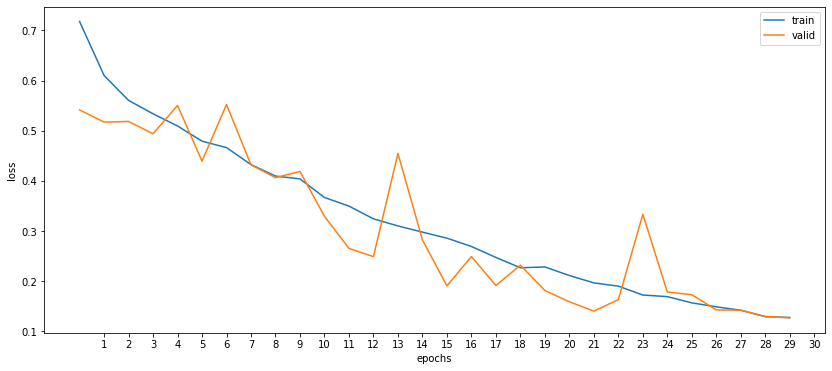

In [86]:
plt.figure(figsize=(14, 6))

plt.plot(range(len(train_loss_history)),
         train_loss_history, label='train')
plt.plot(range(len(valid_loss_history)),
         valid_loss_history, label='valid')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(range(1, 31))
plt.legend()

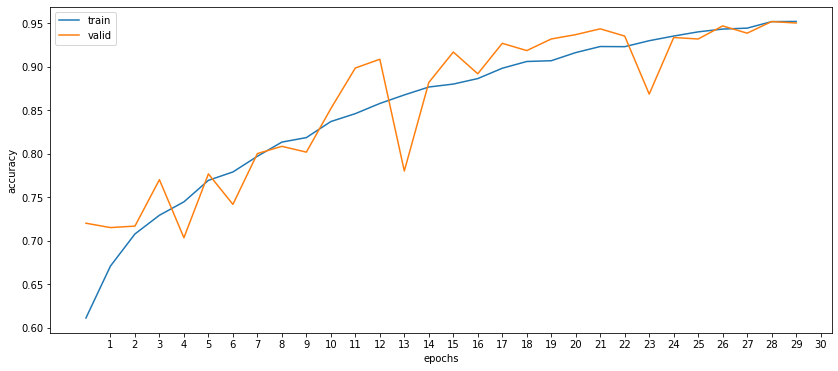

In [87]:
plt.figure(figsize=(14, 6))

plt.plot(range(len(train_accuracy_history)),
         train_accuracy_history, label='train')
plt.plot(range(len(valid_accuracy_history)),
         valid_accuracy_history, label='valid')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xticks(range(1, 31))
plt.legend()

In [96]:
model.eval()
correct_preds = []
uncorrect_preds = []
full_corrects = 0
full_loss = 0

for image, target in test_loader:
    torch.cuda.memory.empty_cache()
    image = image.to(torch.float32).to(device)
    target = target.to(device)
    
    pred = model(image)
    loss = loss_func(pred, target)

    _, pred_cls = torch.max(pred, 1)
    correct = torch.sum(pred_cls == target)

    full_corrects += correct.item()
    full_loss += loss.item()

    for idx in range(len(target)):
        if pred_cls[idx] == target[idx]:
            correct_preds.append((image[idx], pred_cls[idx].item()))
        else:
            uncorrect_preds.append((image[idx], pred_cls[idx].item()))

print('Loss:', full_loss / len(test_loader))
print('Accuracy', full_corrects / len(test_loader.dataset) * 100, '%')

Loss: 0.10982743166387081
Accuracy 96.0 %


In [97]:
print('Number of correct preds:', len(correct_preds))
print('Number of uncorrect preds:', len(uncorrect_preds))

Number of correct preds: 576
Number of uncorrect preds: 24


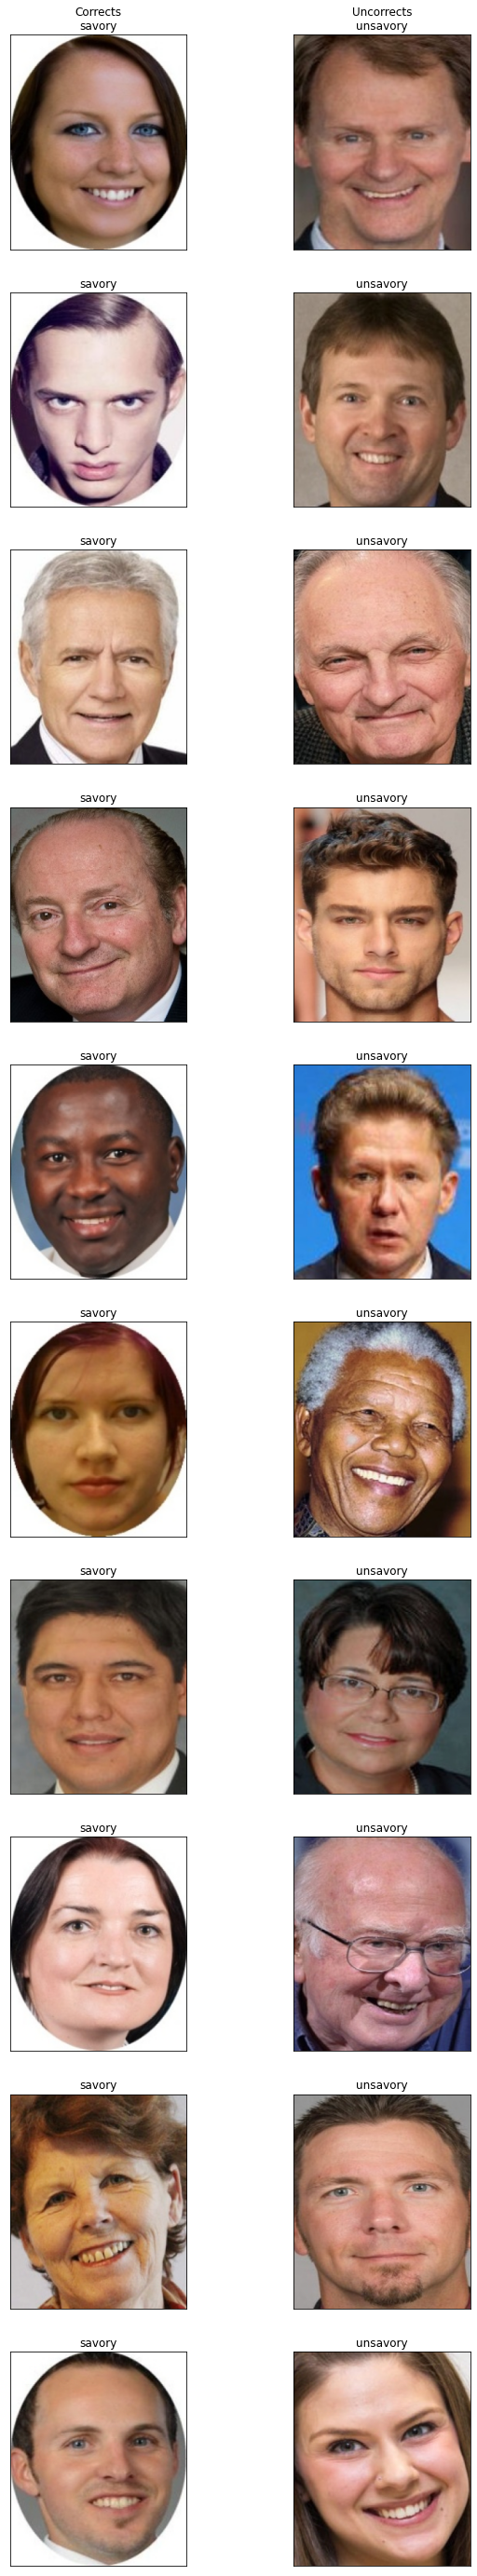

In [100]:
def transform_image(image, class_):
    classes = {0: 'savory', 1: 'unsavory'}
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    class_ = classes[class_]

    return image, class_


fig, axes = plt.subplots(10, 2, figsize=(10, 50))

for idx in range(10):
    correct_image = correct_preds[idx][0]
    num_class = correct_preds[idx][1]
    correct_image, _class_ = transform_image(correct_image, num_class)

    uncorrect_image = uncorrect_preds[idx][0]
    num_class = uncorrect_preds[idx][1]
    uncorrect_image, un_class_ = transform_image(uncorrect_image, num_class)
    

    axes[idx, 0].imshow(correct_image)
    axes[idx, 1].imshow(uncorrect_image)

    axes[idx, 0].set_xticks([])
    axes[idx, 0].set_yticks([])
    axes[idx, 1].set_xticks([])
    axes[idx, 1].set_yticks([])

    if idx == 0:
        axes[idx, 0].set_title(f'Corrects\n{_class_}')
        axes[idx, 1].set_title(f'Uncorrects\n{un_class_}')
    else:
        axes[idx, 0].set_title(_class_)
        axes[idx, 1].set_title(un_class_)